In [1]:
library(gdata)
library(ggplot2)
library(grid)
library(gridExtra)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith


Attaching package: ‘gridExtra’

The following object is masked from ‘package:gdata’:

    combine



In [2]:
GBD <- read.table("../Data/DALY_YLL_deaths_per_region_and_27_diseases_2005.txt")
RCT <- read.table("../Data/RCTs_and_Patients_Nb_local_prop_median_UI_per_region_and_disease.txt")

In [3]:
GBD <- GBD[order(GBD$Region,GBD$Disease),]
RCT <- RCT[order(RCT$Region,RCT$Disease),]

In [35]:
#Disease labels for plot
GBD$Dis_lab <- GBD$Disease
levels(GBD$Dis_lab) <- c("",
               "Cardiovasc.\nand circulatory",
               "Chronic\nrespiratory",
               "Cirrhosis",
               "Congenital\nanomalies",
               "Diabetes, urinary\nmale infertility",
               "Common\ninfections",
               "Digestive",
               "Gynecol.",
               "Hemoglob. and\nhemolytic anemia",
               "Hepatitis",
               "HIV",
               "Leprosy",
               "Malaria",
               "Maternal\ndisorders",
               "Mental and\nbehavioral",
               "Musculosk.",
               "Neglected trop.",
               "Neonatal\ndisorders",
               "Neoplasms",
               "Neurological",
               "Nutritional",
               "Oral",
               "Sense organ",
               "STD",
               "Skin and\nsubcutaneous",
               "Sudden infant death",
               "Tuberculosis")

In [36]:
RCT$Dis_lab <- RCT$Disease
levels(RCT$Dis_lab) <- c("",
unique(as.character(GBD$Dis_lab))[levels(droplevels(GBD$Disease[GBD$Dis_lab!=""]))%in%levels(RCT$Disease)])

In [56]:
#Order of regions: decreasing nb of RCTs
rt <- RCT[RCT$Disease=="All" & !RCT$Region%in%c("All","Non-HI"),]
regs <- as.character(rt$Region[order(rt$Nb_RCTs_med,decreasing=TRUE)])
regs

[1] "High-income"                                     
[2] "Southeast Asia, East Asia and Oceania"           
[3] "North Africa and Middle East"                    
[4] "Central Europe, Eastern Europe, and Central Asia"
[5] "South Asia"                                      
[6] "Latin America and Caribbean"                     
[7] "Sub-Saharian Africa"

In [83]:
L <- list()
for(i in 1:length(regs)){

    r <- regs[i]
    #All burden in region r
    burd_tot <- GBD$burden[GBD$metr=="daly" & GBD$Region==r & GBD$Disease=="all"]
    #All research
    res_tot <- RCT[RCT$Region==r & RCT$Dis=="All",]   

    #Local burden across diseases
    dfb <- GBD[GBD$metr=="daly" & GBD$Region==r & GBD$Disease!="all",]
    dfb$prop <- 100*dfb$burden/burd_tot
    dfb$mes <- "burden"
    dfb <- dfb[,c("Disease","prop","mes","Dis_lab")] 

    #Local research across diseases
    dfr <- RCT[RCT$Region==r & RCT$Disease!="All",]
    dfr$prop <- dfr$Prop_RCTs_med
    dfr$mes <- "research"
    dfr <- dfr[,c("Disease","prop","mes","Dis_lab")]
    dt <- rbind(dfb,dfr)    

    #Uncertainty intervals for local research
    dfre <- RCT[RCT$Region==r & RCT$Disease!="All",]
    dfre$prop_low <- dfre$Prop_RCTs_low
    dfre$prop_up <- dfre$Prop_RCTs_up
    dfre$mes <- "research"
    dfre <- dfre[,c("Disease","prop_low","prop_up","mes")]    
    
    #10 Principales maladies
    diss <- dfb$Disease[order(dfb$prop,decreasing=TRUE)][1:10]
    dt <- droplevels(dt[dt$Disease%in%diss,])
    dfre <- droplevels(dfre[dfre$Disease%in%diss,])
    #Order of diseases
    dt$Disease <- reorder(dt$Disease,new.order=as.character(diss))
    dfre$Disease <- reorder(dfre$Disease,new.order=as.character(diss))
    
    #Highlighting GAPS
    dt$gap <- dt$Disease
    levels(dt$gap) <- unlist(lapply(levels(dt$Disease),
                                    function(x){
                                        ifelse(sum(dfre$Disease==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Disease==x]/
                                        dfre$prop_up[dfre$Disease==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Disease),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    #GGPLOT Object
    p <- ggplot(dt,aes(Disease))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Disease)-0.4,xend=as.numeric(Disease)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Disease)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Dis_lab
#                              ,name=paste("10 Groups of diseases causing highest burden in",r,sep="\n")
                              )

    if(i%%2==1){
    p <- p + scale_y_continuous(limits = c(0,40),breaks=c(0,5,seq(10,40,10)),
#                                name=paste("Local proportion (%) of burden and research in",r,sep="\n")
                                name=paste("Local proportion (%)\nof burden and research")
                                )
    }
    else {p <- p + scale_y_continuous(limits = c(0,40),breaks=c(0,5,seq(10,40,10)),
#                                name=paste("Local proportion (%) of burden and research in",r,sep="\n")
                                name=paste("\n")
                                )
        }
    p <- p + ggtitle(r)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

#    if(i%%2==0) p <- p + theme(axis.title.y=element_text(""))
    L[[i]] <- p
}

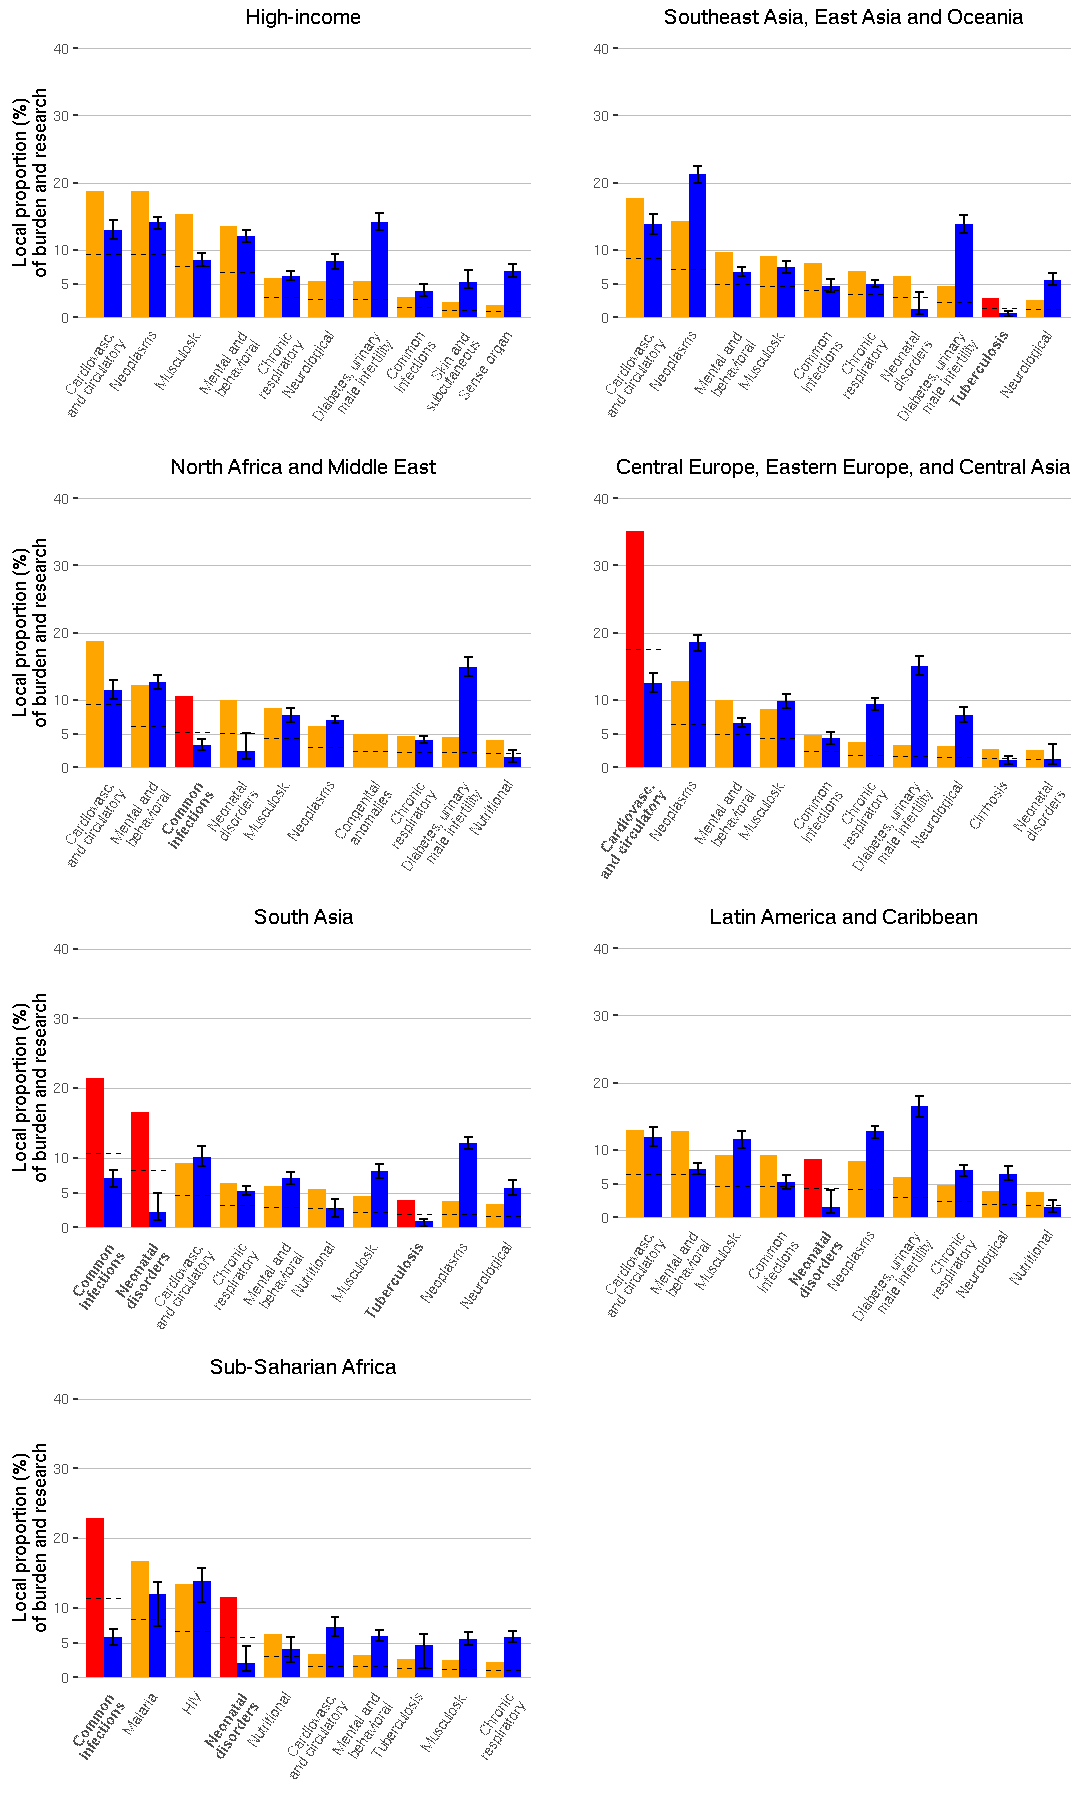

In [101]:
options(repr.plot.width=9, repr.plot.height=15)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]], ncol=2)